<a href="https://colab.research.google.com/github/rinermdhn/ISFEST-2024---Analisis-Sentimen-Mobil-Listrik/blob/main/NASA_Penyisihan_OutputDatcom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Understanding

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics

In [ ]:
!gdown 1voW7R8ZrsqqMK_iEj2aZsznkSTemAZui

Downloading...
From: https://drive.google.com/uc?id=1voW7R8ZrsqqMK_iEj2aZsznkSTemAZui
To: /content/mobil_listrik.csv
100% 266k/266k [00:00<00:00, 37.1MB/s]


In [ ]:
df = pd.read_csv('mobil_listrik.csv')

In [ ]:
df.head()

,id_komentar,nama_akun,tanggal,text_cleaning,sentimen
0,Ugzbll5eyrIy3-gdUUJ4AaABAg,Sqn Ldr,2023-08-06 12:54:49+00:00,saran sih bikin harga ionic sama kayak brio ...,positif
1,UgzEDUiV3OTrV943p8p4AaABAg,lushen ace,2023-08-04 12:16:23+00:00,problem subsidi kualitas diturunin harga dinai...,negatif
2,UgwqJqu6JMF4EH2CsVV4AaABAg,Fatih Al-Ayyubi,2023-08-04 10:17:57+00:00,baik kualitas kembang dulu baik kualitas motor...,positif
3,UgyYicCMR1rKwuOj2Y14AaABAg,yp office,2023-08-04 08:29:54+00:00,model jelek kwalitas buruk harga mahal croot,negatif
4,UgxKAcLuAwZOQK6es-x4AaABAg,Lembur Kuring,2023-08-04 07:55:37+00:00,syarat ngaco woy anak muda blom punya ruma...,negatif


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1517 entries, 0 to 1516
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id_komentar    1517 non-null   object
 1   nama_akun      1516 non-null   object
 2   tanggal        1517 non-null   object
 3   text_cleaning  1515 non-null   object
 4   sentimen       1517 non-null   object
dtypes: object(5)
memory usage: 59.4+ KB


#Data Preparation

## Missing Values

In [ ]:
df.isna().sum()

,0
id_komentar,0
nama_akun,1
tanggal,0
text_cleaning,2
sentimen,0


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

,0
id_komentar,0
nama_akun,0
tanggal,0
text_cleaning,0
sentimen,0


In [ ]:
for col in df.columns:
    non_unique_values = df[col].value_counts()[df[col].value_counts() > 1]
    if not non_unique_values.empty:
        print(f"Non-unique values in column {col}:")
        print(non_unique_values)
        print()

Non-unique values in column nama_akun:
nama_akun
Albert    2
Name: count, dtype: int64

Non-unique values in column tanggal:
tanggal
2023-06-06 14:02:09+00:00    2
2023-06-06 14:38:52+00:00    2
2023-06-06 15:19:27+00:00    2
Name: count, dtype: int64

Non-unique values in column text_cleaning:
text_cleaning
mahal    2
Name: count, dtype: int64

Non-unique values in column sentimen:
sentimen
negatif    868
positif    504
netral     142
Name: count, dtype: int64



## Duplikasi

In [ ]:
df.duplicated().sum()

0

#Exploratory Data Analysis

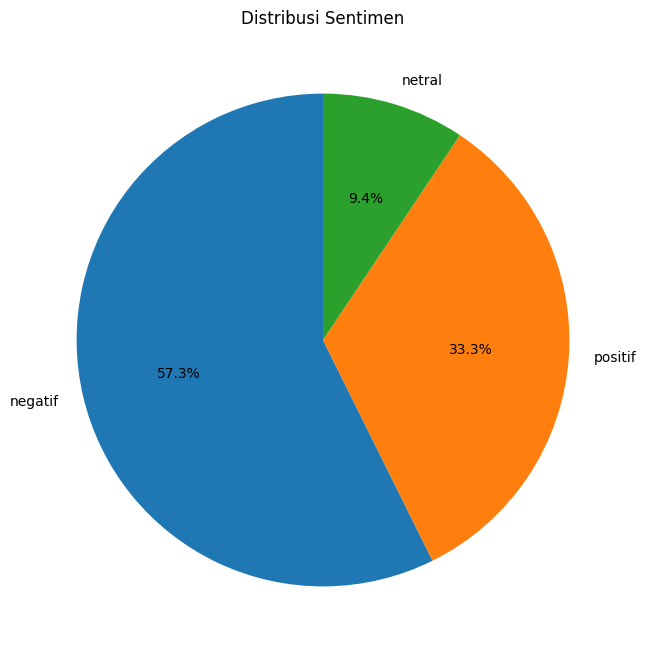

In [ ]:
# Pie Chart Sentimen

sentiment_counts = df['sentimen'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Sentimen')
plt.show()

Terdapat imbalance pada data.

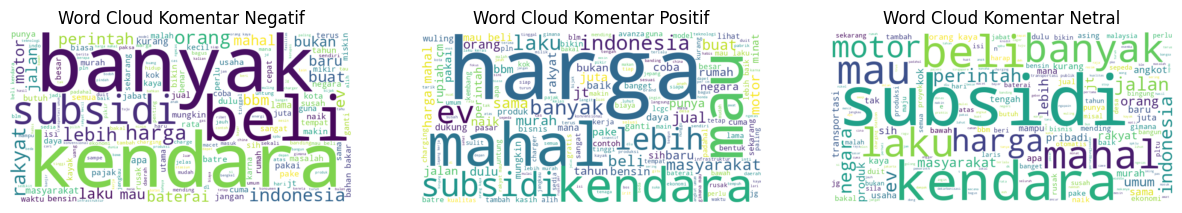

In [ ]:
# Word Cloud

# Memisahkan sentimen positif, negatif, dan netral
pos = df[df['sentimen'] == 'positif']['text_cleaning']
neg = df[df['sentimen'] == 'negatif']['text_cleaning']
net = df[df['sentimen'] == 'netral']['text_cleaning']

wordcloud_pos = WordCloud(width=800, height=400, max_words=200, background_color="white").generate(" ".join(pos))
wordcloud_neg = WordCloud(width=800, height=400, max_words=200, background_color="white").generate(" ".join(neg))
wordcloud_net = WordCloud(width=800, height=400, max_words=200, background_color="white").generate(" ".join(net))

# Menampilkan gambar dengan matplotlib
plt.figure(figsize=(15, 7.5))

# Word Cloud negatif
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud Komentar Negatif')
plt.axis("off")

# Word Cloud positif
plt.subplot(1, 3, 2)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud Komentar Positif')
plt.axis("off")

# Word Cloud netral
plt.subplot(1, 3, 3)
plt.imshow(wordcloud_net, interpolation='bilinear')
plt.title('Word Cloud Komentar Netral')
plt.axis("off")

plt.show()

## Labelling

In [ ]:
# Ubah label jadi integer
# Mendefinisikan dictionary mapping
label_mapping = {
    'negatif': 0,
    'netral': 1,
    'positif': 2,
}

# Aplikasikan mapping ke kolom 'sentimen'
df['sentimen'] = df['sentimen'].replace(label_mapping)

## Handling Imbalance

In [ ]:
df['sentimen'].value_counts()

,count
sentimen,
0,868
2,504
1,142


Dapat dilihat bahwa antar kategori memiliki jumlah yang berbeda, bahkan kategori 1 tidak mencapai seperempatnya kategori 0, hal ini menandakan bahwa data imbalance

In [ ]:
# Split data ke dalam data train dan test
train_data, test_data = train_test_split(
    df,
    test_size=0.1,
    random_state=25
)

# Split data test menjadi data validasi dan test
valid_data, test_data = train_test_split(
    test_data,
    test_size=0.5,
    random_state=25
)

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {valid_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (1362, 5)
Validation data shape: (76, 5)
Test data shape: (76, 5)


In [ ]:
# Mendefinisikan X dan y
X_train = train_data['text_cleaning']
y_train = train_data['sentimen']
X_test = test_data['text_cleaning']
y_test = test_data['sentimen']
X_valid = valid_data['text_cleaning']
y_valid = valid_data['sentimen']

In [ ]:
# Melakukan Oversampling pada data train untuk mengatasi imbalance
ros = RandomOverSampler(random_state=82)
X_train_res, y_train_res = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)

# Mengkonversi X train yang telah di resample menjadi DataFrame
X_train_res = pd.Series(X_train_res.flatten())

In [ ]:
# Jumlah masing-masing kategori setelah Oversampling
y_train_res.value_counts()

,count
sentimen,
0,787
2,787
1,787


## Tokenizer dan Pad Sequences

In [ ]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X_train_res)

X_trains_res = tokenizer.texts_to_sequences(X_train_res)
X_tests = tokenizer.texts_to_sequences(X_test)
X_valids = tokenizer.texts_to_sequences(X_valid)

X_trains_res = pad_sequences(X_trains_res)
X_tests = pad_sequences(X_tests)
X_valids = pad_sequences(X_valids)

## One Hot Encoding

In [ ]:
y_train_onehot_res = to_categorical(y_train_res)
y_test_onehot = to_categorical(y_test)
y_valid_onehot = to_categorical(y_valid)

#Modeling & Evaluation

## Build LSTM Model

In [ ]:
embed_dim = 128
lstm_out = 196

max_length = max(len(x) for x in X_trains_res)

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_shape=(max_length,)))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 272, 128)            │         256,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 272, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 196)                 │         254,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 511,391 (1.95 MB)

 Trainable params: 511,391 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

None


## Fitting dan Validasi

In [ ]:
batch_size = 64
history_validasi = model.fit(X_trains_res, y_train_onehot_res, epochs=25, batch_size=batch_size, validation_data=(X_valids, y_valid_onehot), verbose=1)

Epoch 1/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4017 - loss: 1.0795 - val_accuracy: 0.4737 - val_loss: 1.0104
Epoch 2/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6832 - loss: 0.8134 - val_accuracy: 0.6711 - val_loss: 0.8709
Epoch 3/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8423 - loss: 0.4284 - val_accuracy: 0.6184 - val_loss: 0.9051
Epoch 4/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9475 - loss: 0.1869 - val_accuracy: 0.6974 - val_loss: 0.9110
Epoch 5/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9663 - loss: 0.1156 - val_accuracy: 0.6842 - val_loss: 1.0612
Epoch 6/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9773 - loss: 0.0744 - val_accuracy: 0.6842 - val_loss: 1.2405
Epoch 7/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9864 - loss: 0.0519 - val_accuracy: 0.6842 - val_loss: 1.3042
Epoch 8/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9936 - loss: 0.0299 - val_accuracy: 0.6447 - val_loss:

## Predict dan Evaluasi

In [ ]:
predicted = model.predict(X_tests, batch_size = batch_size)
predicted = np.round(predicted).astype(int)

accuracy_score = metrics.accuracy_score(y_test_onehot, predicted)
print("Accuracy Score: ", accuracy_score)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step
Accuracy Score:  0.8026315789473685


Unnormalized Confusion Matrix


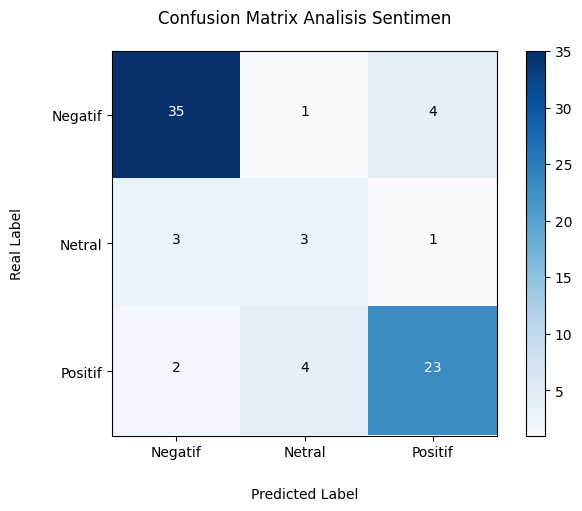

In [ ]:
# Mendefinisikan Confusion Matrix
ConfusionMatrix = confusion_matrix(y_test_onehot.argmax(axis=1), predicted.argmax(axis=1))

# Plot Confusion Matrix
def plot_cm(cm, classes, title, normalized = False, cmap = plt.cm.Blues):
  plt.imshow(cm, interpolation = "nearest", cmap = cmap)
  plt.title(title, pad = 20)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  if normalized:
    cm = cm.astype('float') / cm.sum(axis = 1)[: np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Unnormalized Confusion Matrix")

  threshold = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(j, i, cm[i, j], horizontalalignment = "center", color = "white" if cm[i, j] > threshold else "black")

  plt.tight_layout()
  plt.xlabel("Predicted Label", labelpad = 20)
  plt.ylabel("Real Label", labelpad = 20)

plot_cm(ConfusionMatrix, classes = ["Negatif", "Netral",  "Positif"], title = "Confusion Matrix Analisis Sentimen")

In [ ]:
print(classification_report(y_test_onehot, predicted))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        40
           1       0.38      0.43      0.40         7
           2       0.82      0.79      0.81        29

   micro avg       0.80      0.80      0.80        76
   macro avg       0.69      0.70      0.69        76
weighted avg       0.81      0.80      0.81        76
 samples avg       0.80      0.80      0.80        76

